In [81]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import pmdarima as pm
import prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


## Main Objective

## Load data and Description

In [57]:
df_temp = pd.read_csv(
    "daily-min-temperatures.csv", header=0, parse_dates=[0], index_col=0
)

print(
    "Head:\n",
    df_temp.head(),
)
print(
    "\n describe:\n",
    df_temp.describe(),
)
print(
    "\n \t",
    df_temp.info(),
)

Head:
             Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

 describe:
               Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB

 	 None


### Set Desired Frequency and fill in the missing values

In [58]:
# frequency is daily and it is not set

print(df_temp.index)

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3650, freq=None)


In [59]:
# setting frequency to daily and accounting for missing values

df_temp = df_temp.asfreq("D")

print(df_temp.index)

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3652, freq='D')


In [60]:
# two missing values

df_temp.isna().sum()

Temp    2
dtype: int64

In [61]:
# filling missing values with forward fill

df_temp = df_temp.ffill()

df_temp.isna().sum()  # two missing values

Temp    0
dtype: int64

## Visualizing data to check for stationarity

* There is clear seasonality which renders the data non-stationary

* From and the monthly and quarterly seasonal plot, we see clearly some seasonaly in the data

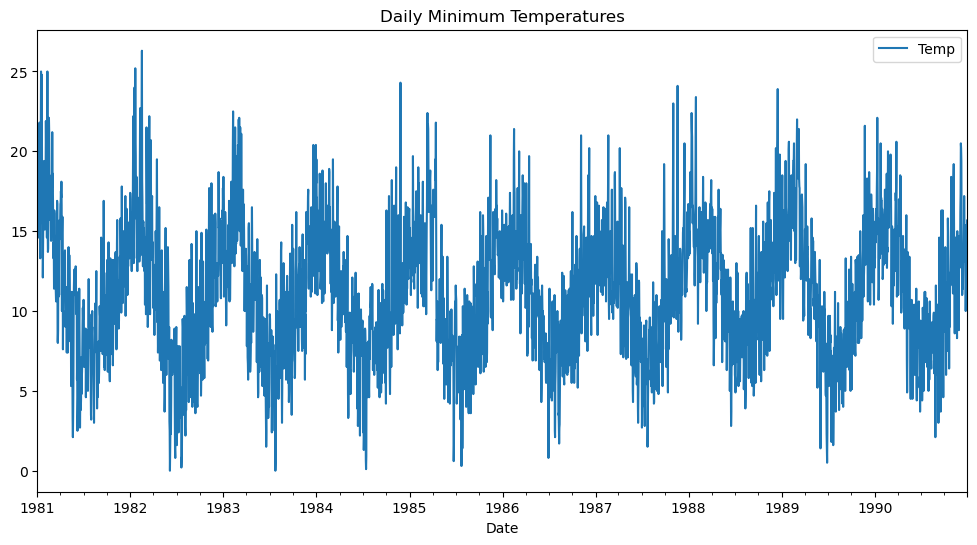

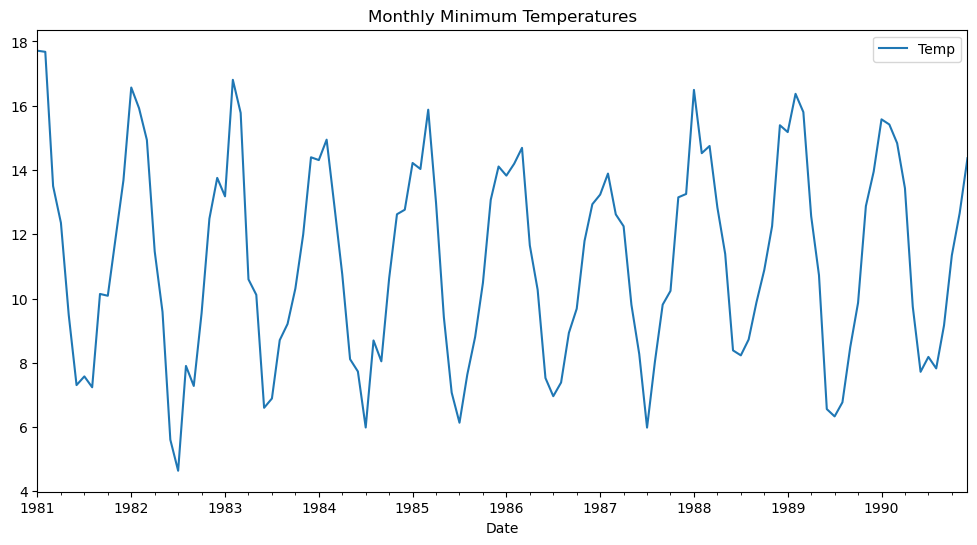

In [62]:
df_temp.plot(figsize=(12, 6), title="Daily Minimum Temperatures")
df_temp.resample("M").mean().plot(figsize=(12, 6), title="Monthly Minimum Temperatures")

plt.show()


Monthly Data Seasonal Plot


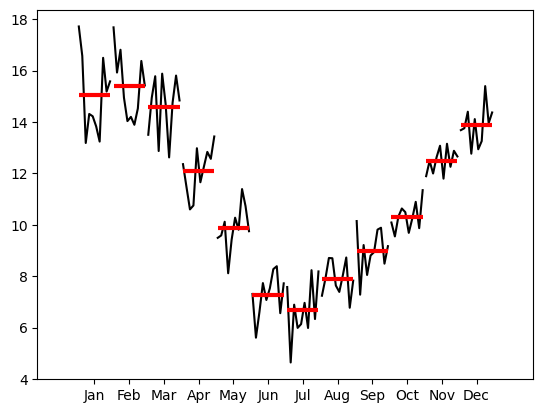

In [63]:
print("\nMonthly Data Seasonal Plot")
m_plot = month_plot(df_temp.Temp.resample("M").mean())


Quarterly Data Seasonal Plot


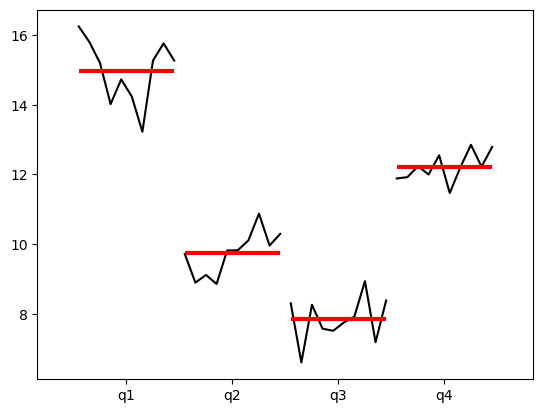

In [64]:
print("\nQuarterly Data Seasonal Plot")
q_plot = quarter_plot(df_temp.Temp.resample("Q").mean())

## Q-Q plot
If the data fits well to a Gaussian distribution, it gives an indication that the the mean and variance are constant. It is preferred to use the qq plot instaed of the histogram as the histograms can be sometimes misleading with the wrong choice of bins.
### White Noise
White noise fit the criteria below of what we expectedfrom a stationary data:
* Const mean
* const variance
* no autocorrelations

The data does not completely fit a Gaussian distribution as you will expect.

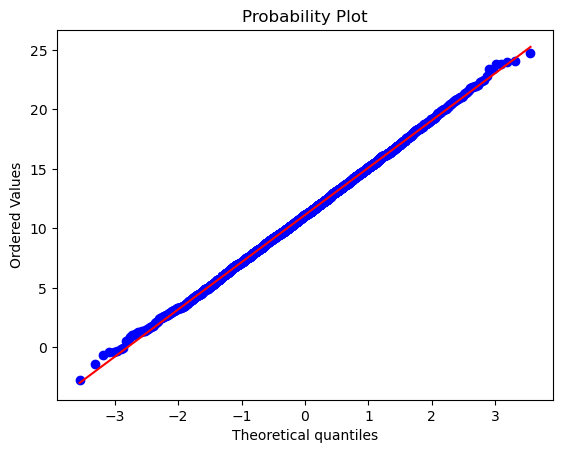

In [65]:
# white noise
np.random.seed(2603)
stats.probplot(
    np.random.normal(df_temp.Temp.mean(),
                     df_temp.Temp.std(), len(df_temp.Temp)),
    plot=plt,
)
plt.show()

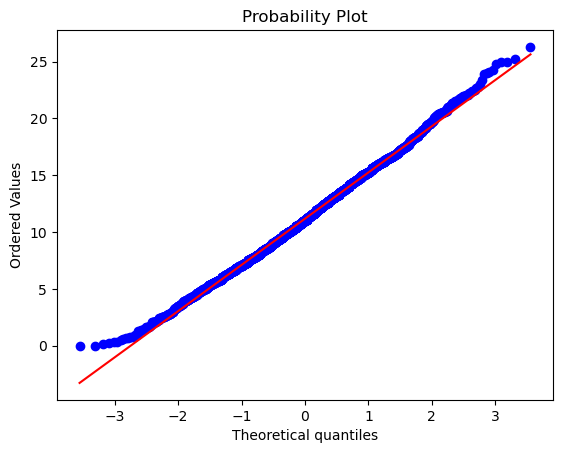

In [66]:
# this is what we expect from time series data not to be normally distributed
stats.probplot(df_temp.Temp, plot=plt)
plt.show()

### Decomposition of signal

This signal appears to additive as the magnitude of the signal does not increase with trend over time. The trend is constantly changing and there is clearly an anunual seasonality in the data. By decomposing the time-series we see the trend and seasonality. The residual appeart stationary

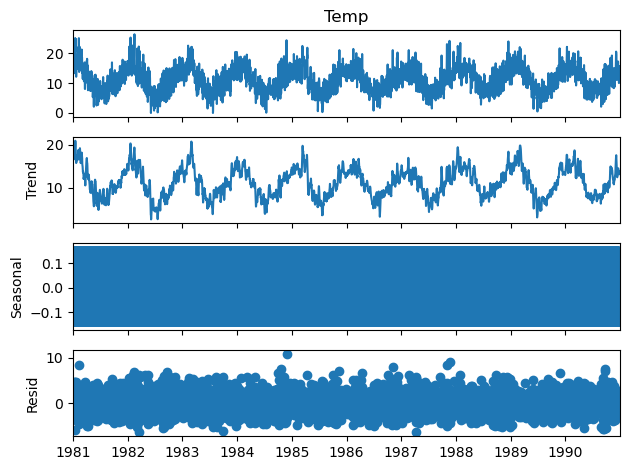

In [67]:
s_dec_additive = seasonal_decompose(df_temp.Temp, model="additive")

s_dec_additive.plot()
plt.show()

## Test of stationarity conditions - complementary check

* Constant mean (condition not met and points the existence of some trend)
* Constant variance (condition not met)
* Weak autocorrelation (we have strong correlations up to last 50 days)


All these point to the fact that the data is not stationary

/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


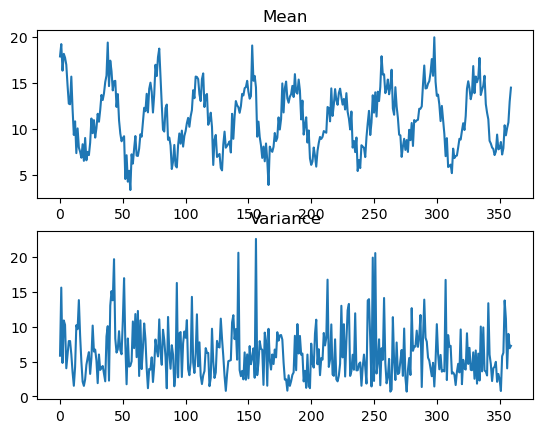

In [68]:
split = np.split(df_temp.Temp[:3600], indices_or_sections=360, axis=0)
# split = np.split(df_temp.residual[:3600], indices_or_sections=360, axis=0)

mean = [section.mean() for section in split]
var = [section.var() for section in split]

plt.subplot(2, 1, 1)
plt.plot(mean)
plt.title("Mean")

plt.subplot(2, 1, 2)
plt.plot(var)
plt.title("Variance")
plt.show()

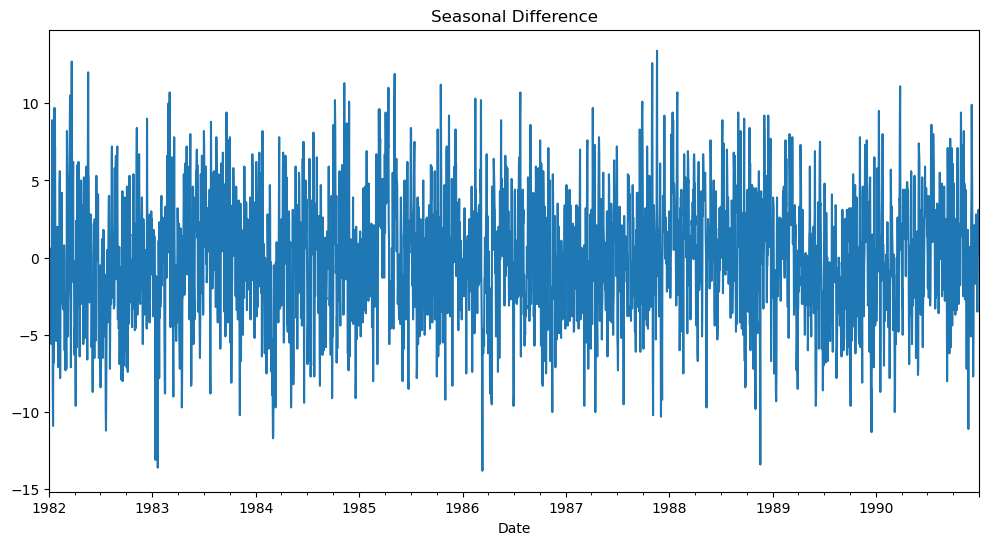

In [70]:
# df_temp["log_temp"] = np.log(df_temp.Temp)

df_temp["lag_365"] = df_temp.Temp.shift(365)

df_temp["seasonal_difference"] = df_temp.Temp - df_temp.lag_365  # + 15

# df_temp["log_temp"].plot(figsize=(12, 6), title="Log of Daily Minimum Temperatures")
# plt.show()

df_temp["seasonal_difference"].dropna().plot(
    figsize=(12, 6), title="Seasonal Difference"
)
plt.show()

#### Auto-Correlation

It has a positive autocorrelation up to a higher number of lags, hence a higher order differencing is needed (Duke ARIMA Guidelines)

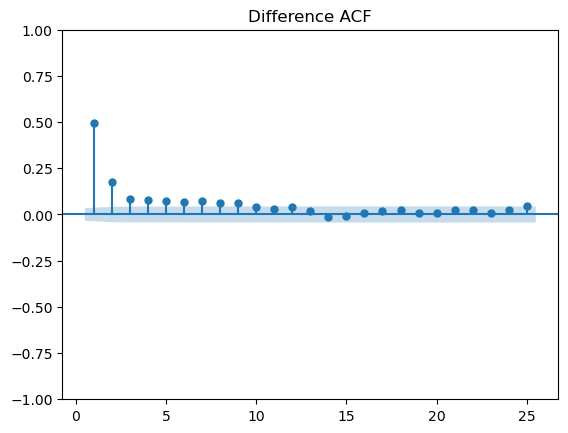

In [71]:
# plot_acf(df_temp.Temp, lags=25, zero=False, title="Temperature ACF")
plot_acf(
    df_temp.seasonal_difference.dropna(), lags=25, zero=False, title="Difference ACF"
)
plt.show()

#### Partial Auto-Correlation

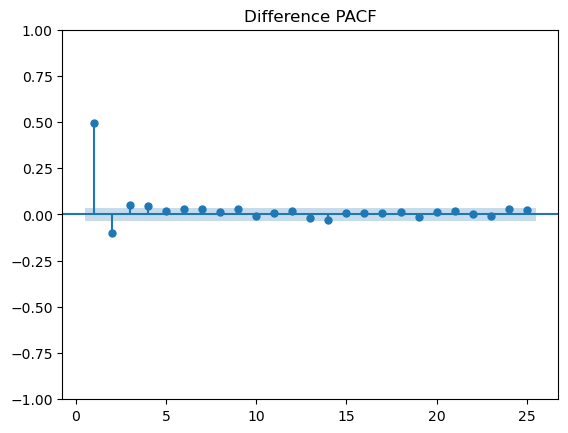

In [72]:
# plot_pacf(df_temp.Temp, lags=25, zero=False, title="Temperature PACF")
plot_pacf(
    df_temp.seasonal_difference.dropna(), lags=25, zero=False, title="Difference PACF"
)

plt.show()

## Statistical test for stationarity - Augmented Dickey Fuller test

P-value ≤ significance level
Test statistic ≤ critical value
If the p-value is less than or equal to the significance level or if the test statistic is less than or equal to the critical value, the decision is to reject the null hypothesis. Because the data provide evidence that the data are stationary, the recommendation of the analysis is to proceed without differencing.

P-value > significance level
Test statistic > critical value
If the p-value is greater than the significance level or if the test statistic is greater than the critical value, the decision is to fail to reject the null hypothesis. Because the data do not provide evidence that the data are stationary, the recommendation of the analyis is to determine whether differencing makes the mean of the data stationary.


For this work, the p-value is very less than the significance level of 0.05 and the ADF test statistics is less than any of the critical values and hence we can reject the null hypothesis (non stationarity) and take that the series as stationary.The test result is misleading as visualization paints a different picture.

In [69]:

adfuller(df_temp.Temp),

((-4.440933664385148,
  0.0002510472415292601,
  20,
  3631,
  {'1%': -3.4321522387754775,
   '5%': -2.862336328589075,
   '10%': -2.567193897993964},
  16651.240027625234),)

In [75]:
adfuller(df_temp.diff(1).dropna().values.flatten()), adfuller(
    df_temp.seasonal_difference.dropna().values.flatten())

((-23.90183507708432,
  0.0,
  38,
  9819,
  {'1%': -3.4310161585056123,
   '5%': -2.861834401835228,
   '10%': -2.5669267049677167},
  47020.82581454067),
 (-17.575090919921337,
  4.033390332119365e-30,
  6,
  3280,
  {'1%': -3.4323452515445956,
   '5%': -2.862421583712013,
   '10%': -2.5672392854885486},
  17157.79969789907))

## Split data to train and test set

No shuffling is done for time-series data

In [77]:
train, test = df_temp.Temp[:-7], df_temp.Temp[-7:]

## Model Selection

Since the time-series is non-stationary, we will not use the ARMA models as they rely on stationarity. We use SARIMA model as the series has trend and seasonality. For the choice of hyperparameter for this models we use a grid search approach.

In [78]:
model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 365))

In [80]:
pred = model.predict(params, start=len(train), end=len(train) + len(test) - 1, dynamic=False)


TypeError: Model.predict() missing 1 required positional argument: 'params'

15:05:04 - cmdstanpy - INFO - Chain [1] start processing
15:05:05 - cmdstanpy - INFO - Chain [1] done processing
/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


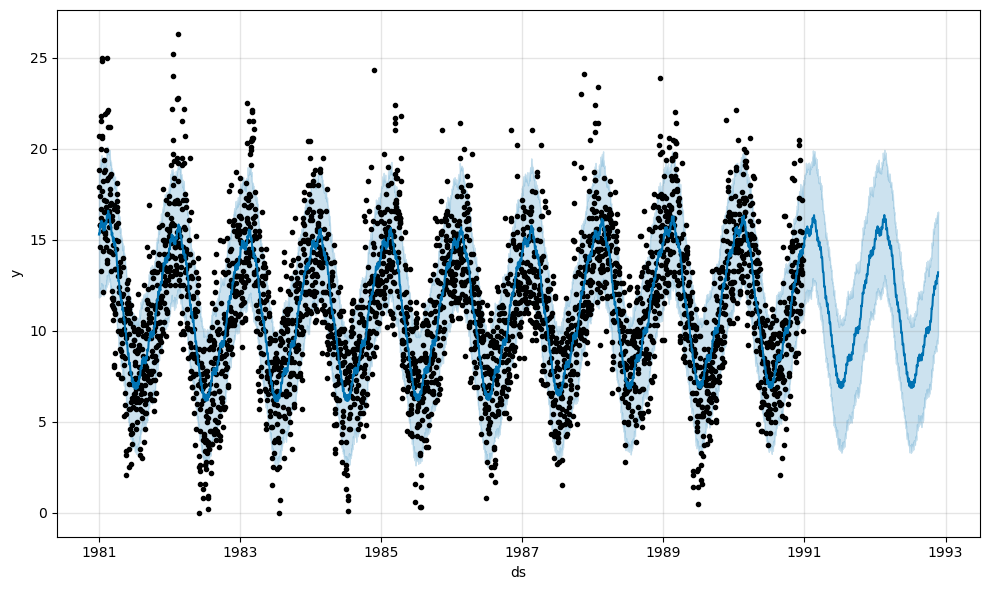

In [86]:
# fit model
m = prophet.Prophet()

df_p = {}
df_p["ds"] = df_temp.index
df_p["y"] = df_temp.Temp.values
df_p = pd.DataFrame(df_p)

train_p, test_p = df_p[:-7], df_p[-7:]

m.fit(train_p)

future = m.make_future_dataframe(periods=len(test_p) * 100)
forecast = m.predict(future)

# plot forecast
m.plot(forecast)
plt.show()

/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/godwin/Desktop/Organised/python/python/timeSeriesPandas/.venv2/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning: The behavior of DatetimeProperties.to_p

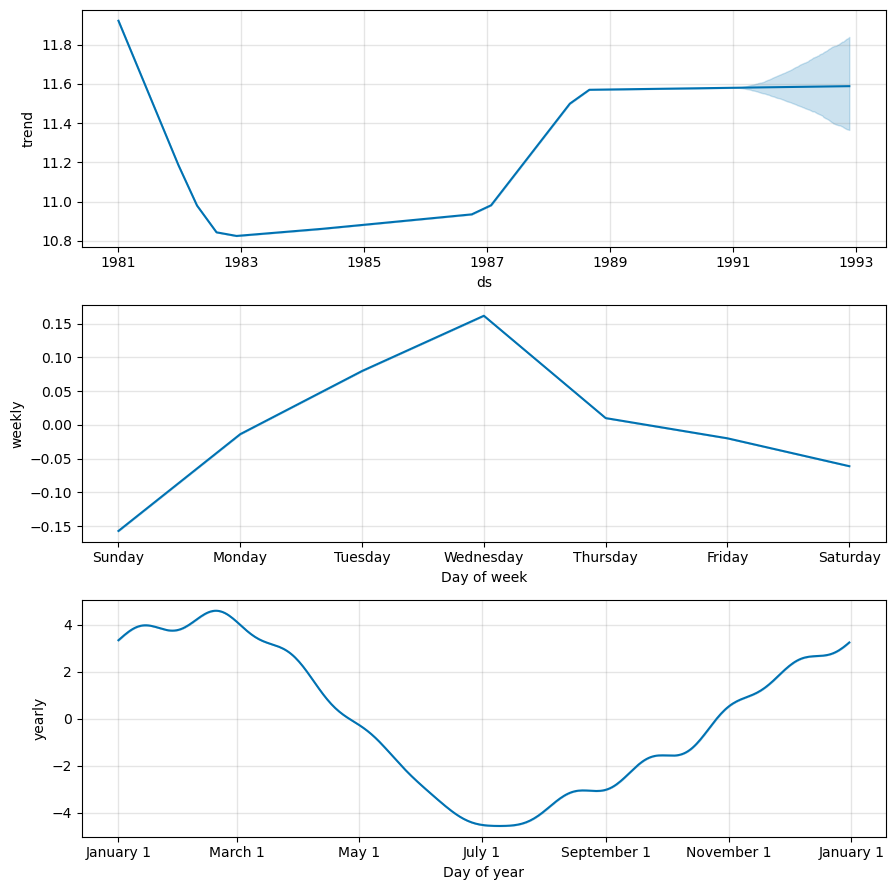

In [87]:
m.plot_components(forecast)
plt.show()

## Evaluating model

In [22]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.api import Holt

# simple average
predsa = [train.mean()] * len(test)

# moving average
predma = [train.rolling(window=7).mean().iloc[-1]] * len(test)

# single exponential smoothing
predses = SimpleExpSmoothing(train).fit(optimized=True).forecast(len(test))

# double exponential smoothing
preddes = Holt(train).fit(optimized=True).forecast(len(test))

# tirple exponential smoothing
predtes = (
    ExponentialSmoothing(
        train, trend="additive", seasonal="additive", seasonal_periods=365
    )
    .fit(optimized=True)
    .forecast(len(test))
)

In [23]:
print("Simple Average MSE:", mean_squared_error(test, predsa))
print("Moving Average MSE:", mean_squared_error(test, predma))
print("Single Exponential Smoothing MSE:", mean_squared_error(test, predses))
print("Double Exponential Smoothing MSE:", mean_squared_error(test, preddes))
print("Triple Exponential Smoothing MSE:", mean_squared_error(test, predtes))
print("SARIMA MSE: ", mean_squared_error(test, pred))

# print("AutoReg MSE:", mean_squared_error(test, pred))

Simple Average MSE: 8.25550478523755
Moving Average MSE: 0.8293877551020403
Single Exponential Smoothing MSE: 3.9475351143245283
Double Exponential Smoothing MSE: 6.561415199453889
Triple Exponential Smoothing MSE: 1.5315489236409057
SARIMA MSE:  195.93498667141037


In [66]:
dt = {}
dt["test"] = test.values
dt["pred"] = pred.values
dt["predsa"] = predsa
dt["predma"] = predma
dt["predses"] = predses
dt["preddes"] = preddes
dt["predtes"] = predtes

dt = pd.DataFrame(dt)
dt.index = test.index

dt.head()

,test,pred,predsa,predma,predses,preddes,predtes
Date,,,,,,,
1990-12-25,12.9,11.566122,11.17476,13.928571,12.133941,11.577662,12.886475
1990-12-26,14.6,12.841773,11.17476,13.928571,12.133941,11.554722,11.856779
1990-12-27,14.0,13.257010,11.17476,13.928571,12.133941,11.531783,12.417709
1990-12-28,13.6,13.285835,11.17476,13.928571,12.133941,11.508843,13.300312
1990-12-29,13.5,13.236928,11.17476,13.928571,12.133941,11.485904,13.436989


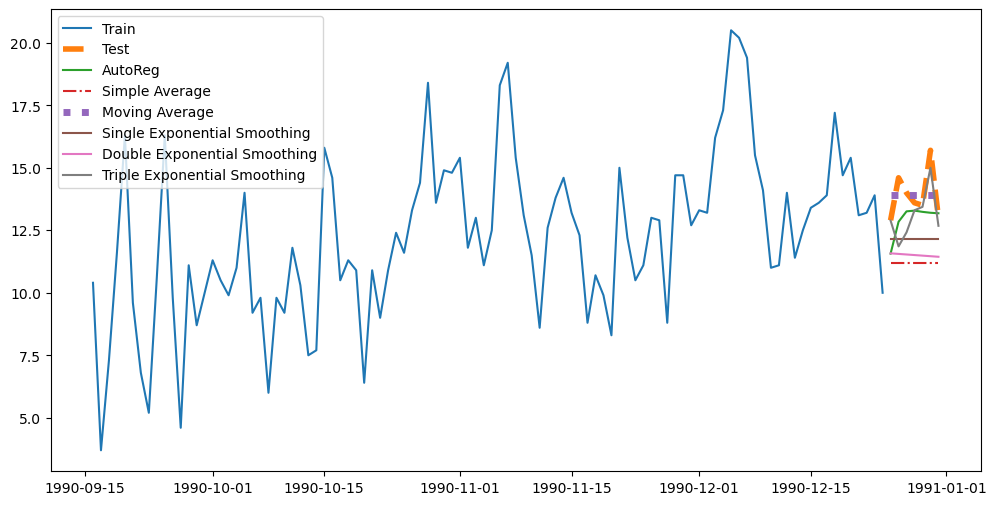

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(train[-100:], label="Train")
plt.plot(dt.test, label="Test", ls="--", lw=4)
plt.plot(dt.pred, label="AutoReg")
plt.plot(dt.predsa, label="Simple Average", ls="-.")
plt.plot(dt.predma, label="Moving Average", ls=":", lw=5)
plt.plot(dt.predses, label="Single Exponential Smoothing")  # SES
plt.plot(dt.preddes, label="Double Exponential Smoothing")  # DES
plt.plot(dt.predtes, label="Triple Exponential Smoothing")  # TES
plt.legend(loc="upper left")
plt.show()

## Making future predictions

In [24]:
pred_future = result.predict(start=len(df_temp.Temp), end=len(df_temp.Temp) + 7)

print("future predictions for the next 7 days:\n \n", pred_future)

future predictions for the next 7 days:
 
 1991-01-01    12.370871
1991-01-02    12.294449
1991-01-03    12.203738
1991-01-04    12.245950
1991-01-05    12.303723
1991-01-06    12.311781
1991-01-07    12.273367
1991-01-08    12.220515
Freq: D, dtype: float64


## Woking on new data